# Support Vector Machines and a short introduction to kernel theory

On va se concentrer aujourd'hui sur une approche géométrique à la classification et à la régression.
- On commence par poser les principales intuitions en essayant de séparer des points par une droite ([#](#Séparation-linéaire)) et cela nous mène à poser un problème d'optimisation sous contraintes.
- Puis on fait un crochet par le cours pour formaliser ces premières idées, puis les généraliser au cas de points non séparables linéairement.
- On revient au notebook pour pratiquer sur deux exemples graphiques ([#](#Les-SVM-dans-le-cas-linéairement-séparable) puis [#](#Le-cas-bruité)).
- Puis un troisième exemple graphique où on va toucher aux limites de la méthode [#](#La-limite-de-la-séparabilité-linéaire).
- Pour nous permettre de travailler avec des concepts non-linéairement séparables on introduit l'idée de *projection* de nos données dans un autre espace, au travers d'un petit exemple concret ([#](#Première-intuition-vers-le-"kernel-trick")).
- On revient au cours pour poser un peu mieux la théorie.
- On pratique enfin avec des SVM non-linéaires et on applique les outils de scikit-learn qu'on a explorés en chemin sur un problème au choix ([#](#SVM-et-noyaux)).

Notez que ce notebook n'aborde pas du tout le problème de la régression, qu'on ne verra que du point de vue formel pendant la partie de cours. Si la théorie est extrêmement similaire au cas de la classification, les cas d'usage de la régression à vecteurs supports méritent une discussion à part (qu'on aura dans la partie de cours).

## Séparation linéaire

Commençons par quelques `import`.

In [1]:
from sklearn import svm
from sklearn import datasets
from sklearn.utils import shuffle
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sopt

Considérons les données issues du fichiers `sep_lin.csv`.

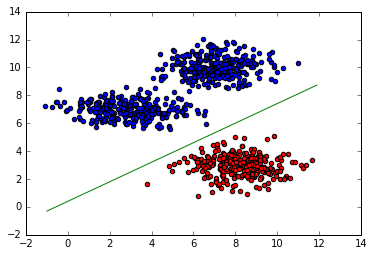

In [2]:
res = np.loadtxt("sep_lin.csv", delimiter=',')
X = res[:,0:-1]
y = res[:,-1].astype(int)
Xblue = X[y==-1]
Xred = X[y==1]
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = 0.7*XX+0.4
_=plt.plot(XX,YY,c='g')

Ces données (simulées) représentent des situations de test $(x_0,x_1)$ de composants électroniques et la réponse $y$ du composant au test. On cherche à généraliser à partir de ces données et à construire une droite qui sépare au mieux les points pour pouvoir prédire la valeur d'un nouveau test (et pouvoir écrire les bonnes tolérances sur l'étiquette du produit vendu). Quel est le meilleur séparateur linéaire pour ces données ?
<div class="alert alert-warning">
**Exercice collectif:** Formalisons (ensemble) cette recherche du meilleur séparateur linéaire comme un problème de maximisation de l'écart entre le séparateur et les points.
</div>

** Correction :**
$$\max_{M,w,w_0} M$$
$$y_i(w^Tx_i + w_0) \geq M, \forall i \in [1,N] \\$$
$$\|w\| = 1$$

<div class="alert alert-warning"> **Exercice:** Implémentez la résolution de ce problème d'optimisation. On utilisera la méthode fmin_slsqp de scipy.optimize. Affichez la droite séparatrice et la marge.
</div>

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.722663810856
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
[ 0.72266381  0.42124178 -0.90694838  1.88363065]


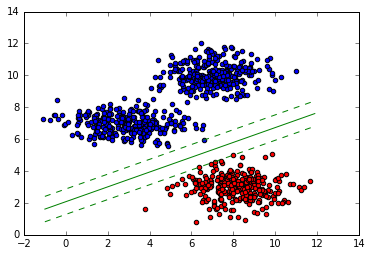

In [3]:
### VOTRE CODE
def func(x):
    """x = (M,w_1,w_2,b)"""
    return -x[0]

def ineq_constr(x):
    """x = (M,w_1,w_2,b)"""
    return y*(x[1]*X[:,0] + x[2]*X[:,1] + x[3]*np.ones(X.shape[0])) - x[0]*np.ones(X.shape[0])

def eq_const(x):
    return x[1]*x[1]+x[2]*x[2]-1

#?sopt.fmin_slsqp
x0 = np.array([0.,0.7,-1.,0.4])
res = sopt.fmin_slsqp(func, x0, f_eqcons=eq_const, f_ieqcons=ineq_constr)
print(res)
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(res[1]*XX+res[3])/res[2]
plt.plot(XX,YY,c='g')
YY = -(res[1]*XX+res[3]+res[0])/res[2]
plt.plot(XX,YY,'g--')
YY = -(res[1]*XX+res[3]-res[0])/res[2]
_=plt.plot(XX,YY,'g--')

On a été un peu paresseux sur le problème précédent : c'est un problème de minimisation d'une fonction linéaire, sous des constraintes inégalité linéaires et une contrainte égalité quadratique. Jouons un peu avec le problème.

- 1ère remarque :
On a défini géométriquement $M$ comme la plus petite distance Euclidienne entre un point et la droite séparatrice. Mais, en soi, dans notre problème d'optimisation, la contrainte $\|w\|=1$ est arbitraire (elle permet simplement que $w^T x + w_0$ corresponde effectivement à une distance Euclidienne). Elle est nécessaire à ce qu'on n'aie qu'un seul vecteur $w$ par hyperplan, mais on aurait pu prendre n'importe quelle valeur $k$ pour la constante à droite de l'égalité. Avec $k=2$ par exemple, on aurait trouvé un $w$ aux coefficients $\sqrt{2}$ fois plus grands, et une valeur $\sqrt{2}$ fois plus petite pour $M$.
- 2ème remarque : on se rend bien compte que $M$ et $\|w\|$ sont liées et on aimerait bien en éliminer une des deux (en utilisant la contrainte égalité). Pour cela, on propose le changement de variable $w' = \frac{w}{M}$ et $w'_0 = \frac{w_0}{M}$.
<div class="alert alert-warning"> **Exercice:** Utilisez ce changement de variable pour éliminer $M$ du problème d'optimisation.
</div>

** Correction : **
Dans ce cas, les contraintes inégalité deviennent :
$$y_i (w'^T x_i + w'_0) \geq 1$$
La contrainte égalité devient :
$$M = \frac{1}{\|w'\|}$$
Il suffit alors de remplacer l'expression de $M$ donnée par la contrainte égalité dans la fonction objectif et on obtient:
$$\max_{w',w'_0} \frac{1}{\|w'\|}$$
$$y_i (w'^T x_i + w'_0) \geq 1, \forall i \in [1,N]$$

En remarquant que maximiser $\frac{1}{\|w\|}$ est équivalent à minimiser $\|w\|$, et donc à minimiser $\frac{1}{2}\|w\|^2$, on obtient en fin de compte :
$$\min_{w,w_0} \frac{1}{2}\|w\|^2$$
$$y_i (w^T x_i + w_0) \geq 1, \forall i \in [1,N]$$

Ce problème est un problème de programmation quadratique, un grand classique de l'optimisation non-linéaire.
<div class="alert alert-warning"> **Exercice:** Ecrivez le Lagrangien de ce problème.</div>

**Correction :**
$$L(w,w_0,\alpha) = \frac{1}{2}|\|w\|^2 - \sum_{i = 1}^N \alpha_i (y_i (w^T x_i + w_0)-1)$$

<div class="alert alert-warning"> **Exercice:** Ecrivez les conditions de Karush-Kuhn-Tucker du premier ordre pour ce problème.</div>
Rappel : pour un problème quadratique convexe (comme c'est le cas ici), les conditions du premier ordre sont des conditions nécessaires et suffisantes.

** Correction :**
Conditions du premier ordre KKT:
$$(w,w_0)\textrm{ minimum local} \Rightarrow \exists \alpha \in \mathbb{R}^N / \left\{\begin{array}{l} 
\frac{\partial L}{\partial w} = 0 \\
\frac{\partial L}{\partial w_0} = 0 \\
\alpha_i (y_i (w^T x_i + w_0)-1) = 0, \forall i \in [1,N] \\
\alpha_i \geq 0, \forall i \in [1,N]
\end{array}\right.$$
Ou encore :
$$(w,w_0,\alpha)\textrm{ minimum local} \Rightarrow \exists \alpha \in \mathbb{R}^N / \left\{\begin{array}{l} 
w - \sum_{i=1}^N \alpha_i y_i x_i = 0, \forall i \in [1,N] \\
\sum_{i=1}^N \alpha_i y_i = 0\\
\alpha_i (y_i (w^T x_i + w_0)-1) = 0, \forall i \in [1,N] \\
\alpha_i \geq 0, \forall i \in [1,N]
\end{array}\right.$$

On note que le $w$ optimal est combinaison linéaire des $x_i$. Qui plus est, les coefficients de cette combinaison linéaire sont les coefficients de KKT (à une multiplication par $y_i$ près), or pour tous les $x_i$ qui ne saturent pas la contrainte (c'est-à-dire, en fin de compte, les $x_i$ qui ne définissent pas la marge) on a $\alpha_i=0$ d'après la condition du premier ordre. Donc au final, $w$ est une combinaison linéaire d'une poignée seulement des $x_i$ qu'on appelle *vecteurs supports*.<br>
<br>
Tout le problème consiste donc à trouver les $\alpha_i$ optimaux.
<div class="alert alert-warning"> **Exercice:** Remplacez $w$ et $w_0$ dans l'expression du Lagrangien et déduisez-en la forme du problème dual.</div>

** Correction : **
$$\max_{\alpha\geq 0} \left[\sum_{i=1}^N \alpha_i - \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \alpha_i \alpha_j y_i y_j x_i^T x_j \right]$$
$$\sum a_i y_i = 0$$

Ce problème est généralement résolu par l'algorithme SMO qu'on ne détaillera pas ici.<br>
<br>
Pour vérifier nos développements précédents, on peut implémenter le problème SVM où on a éliminé $M$.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.957408743685
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
[ 2.60651025  0.58290145 -1.25500733]
margin: 0.722663811759


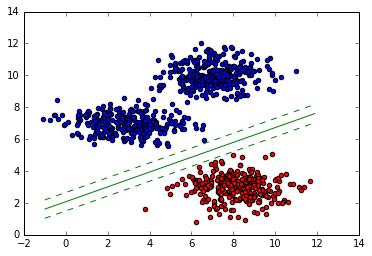

In [4]:
### VOTRE CODE

def func(w):
    """w=(w_0,w_1,w_2)"""
    return .5*(w[1]**2 + w[2]**2)

def ineq_constr(w):
    """w=(w_0,w_1,w_2)"""
    return y*(w[1]*X[:,0] + w[2]*X[:,1] + w[0]*np.ones(X.shape[0])) - np.ones(X.shape[0])

x0 = np.array([0.4,0.7,-1.])
res = sopt.fmin_slsqp(func, x0, f_ieqcons=ineq_constr)
print(res)
#M = 1./np.sqrt(res[1]**2 + res[2]**2)
M = 1. / np.linalg.norm(np.array([res[1],res[2]]))
print("margin:", M)
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(res[1]*XX+res[0])/res[2]
plt.plot(XX,YY,c='g')
YY = -(res[1]*XX+res[0]+M)/res[2]
plt.plot(XX,YY,'g--')
YY = -(res[1]*XX+res[0]-M)/res[2]
_=plt.plot(XX,YY,'g--')

Prenons quelques minutes pour formaliser tout ça dans le cas général avant de passer à la suite.

## Les SVM dans le cas linéairement séparable

Entraînons une SVM fournie par `scikit-learn` sur les données précédentes.

Indices SV:  [461 327 694]
Coord SV: [[ 6.60878688  5.94321765]
 [ 6.37953023  4.24312078]
 [ 8.0063879   4.99873206]]
SV per class: [1 2]
alpha_i:  [[-0.95753541  0.46442409  0.49311133]]
w_i: [ 0.58270058 -1.25530248]
w_0: [ 2.60941083]
Margin: 0.722568197986
w^T x0 + w0: [-1.00018105]
w^T x1 + w0: [ 1.00036678]
w^T x2 + w0: [ 0.99981699]


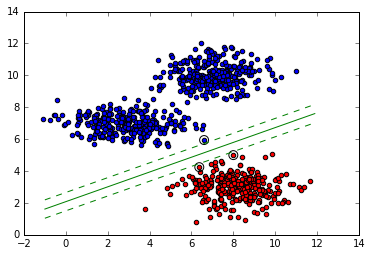

In [5]:
mySVC = svm.SVC(kernel='linear')
mySVC.fit(X,y)

w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("Indices SV: ",mySVC.support_)
print("Coord SV:", mySVC.support_vectors_)
print("SV per class:", mySVC.n_support_)
print("alpha_i: ", mySVC.dual_coef_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# On affiche le séparateur, la marge, les SV
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')
_=plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, facecolors='none')


## Le cas bruité
Construisons à présent un exemple un peu plus difficile, non-linéairement séparable.

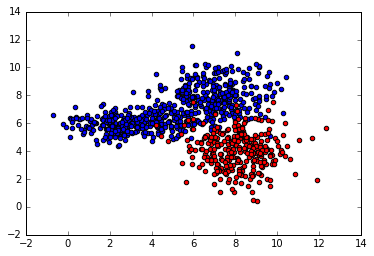

In [6]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.0, n_samples=300, n_features=2, n_classes=1)
X1[:,0] = 3. + X1[:,0]
X1[:,1] = 6. + X1[:,1]/2.5
X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X2[:,0] = 8. + X2[:,0]
X2[:,1] = 4. + X2[:,1]
X3, y3 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X3[:,0] = 7. + X3[:,0]
X3[:,1] = 8. + X3[:,1]
X = np.concatenate((X1, X2, X3))
y = np.concatenate((y1, - y2 + 1, y3))
y = 2*y-1
X, y = shuffle(X, y)
Xblue = X[y==-1]
Xred = X[y==1]

# Display
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

<div class="alert alert-warning">**Exercice: ** en vous inspirant de l'exemple précédent, entraînez une SVC sur ces données, affichez l'hyperplan séparateur, les vecteurs supports, les marges. Retrouvez les résultats du cours sur les valeurs des coefficients des vecteurs supports. Faites varier $C$.</div>

SV per class: [45 44]
w_i: [ 0.72083741 -1.57963658]
w_0: [ 3.92939689]
Margin: 0.575925818058
w^T x0 + w_0: [-0.79051916]
w^T x1 + w_0: [-0.35464004]
w^T x2 + w_0: [-0.9892138]


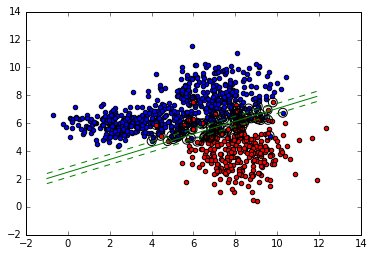

In [7]:
### VOTRE CODE

mySVC = svm.SVC(kernel='linear')
mySVC.fit(X,y)

w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# On affiche le séparateur, la marge, les SV
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')
_=plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, facecolors='none')

## La limite de la séparabilité linéaire

On introduit enfin un dernier exemple (qui vous dit peut-être quelque chose).

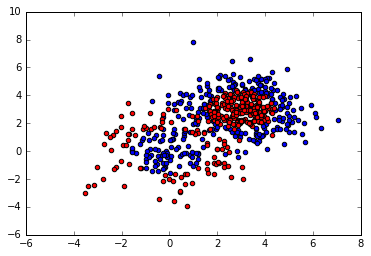

In [8]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

<div class="alert alert-warning">**Exercice: ** A vous de jouer pour construire une SVC... et conclure sur les limites des séparateurs linéaires.</div>

SV per class: [285 294]
w_i: [  6.93317437e-05  -3.01664452e-05]
w_0: [ 0.99991766]
Equation de la droite x2 = 2.29830672102 x1 +  [ 33146.68531718]
Margin: 13225.7256242
w^T x0 + w_0: [ 0.99972641]
w^T x1 + w_0: [ 0.99990652]
w^T x2 + w_0: [ 1.00012164]


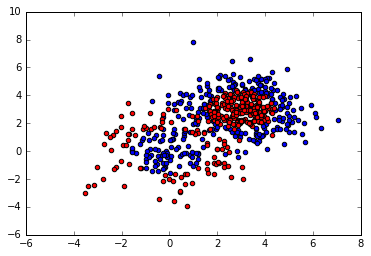

In [10]:
### VOTRE CODE

mySVC = svm.SVC(kernel='linear')
mySVC.fit(X,y)

w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Equation de la droite x2 =", -w[0]/w[1], "x1 + ", -w0/w[1])
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# On affiche le séparateur, la marge, les SV
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')
_=plt.ylim(-6,10)
#_=plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, facecolors='none')

## Première intuition vers le "kernel trick"
On va introduire un exemple qui pourrait bien nous aider. Les données ci-dessous proviennent d'un test de mise sous tension ($U$) d'un composant et indiquent si ce dernier fonctionne ou non.

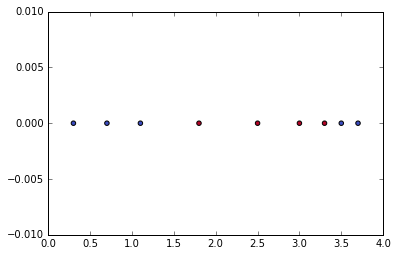

In [16]:
U = np.array([[0.3, 0.7, 1.1, 1.8, 2.5, 3.0, 3.3, 3.5, 3.7]]).T
G = np.array( [ -1,  -1,  -1,   1,   1,   1,   1,  -1,  -1])
plt.figure()
_=plt.scatter(U, np.zeros((U.shape[0],1)), c=G, cmap = plt.cm.coolwarm)

A votre avis, est-ce pertinent de construire un classifieur linéaire sur ces données ?<br>
<br>
Un ingénieur ayant du métier sait que $U$ n'est pas un bon critère pour séparer les points qui fonctionnent bien de ceux qui ne fonctionnent pas. En revanche, son expérience lui indique que si $V = (U-2)^2$ n'est pas plus utile en soi, le couple (U,V) l'est.

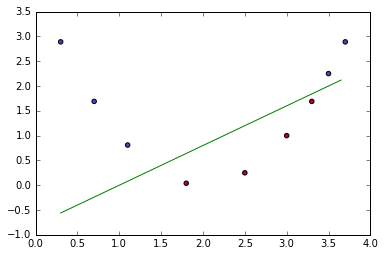

In [18]:
V = (2-U)**2
plt.figure()
plt.scatter(U, V, c=G, cmap = plt.cm.coolwarm)
XX = np.arange(np.min(U), np.max(U), 0.05)
YY = -.8+.8*XX
_=plt.plot(XX,YY,'g')

Nos neuf points sont maintenant parfaitement séparables par un classifieur linéaire. On n'a pourtant introduit aucune information supplémentaire dans le problème. On a simplement *projeté* nos points $x$ non séparables linéairement dans un espace de dimension plus grande où un séparateur linéaire existe.<br>
<br>
L'idée est séduisante et on souhaiterait la généraliser. Comment trouver la bonne transformation sans expérience préalable ? Allons formaliser tout ça en cours avant de revenir ici.

## SVM et noyaux
On reprend les dernières données non-séparables.
<div class="alert alert-warning">**Exercice :** A vous de jouer, construisez une SVM à noyau Gaussien sur ces données. Faites varier $C$.</div>
Pour vous faciliter l'affichage, vous pouvez utiliser la fonction définie ci-dessous (qui suppose que les données ont été chargées au préalable).

SV per class: [111 111]


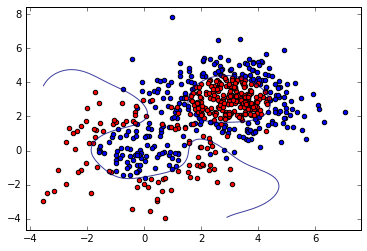

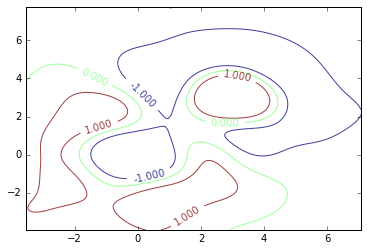

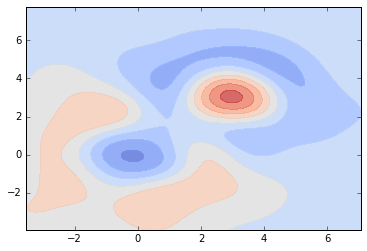

In [21]:
# On affiche le séparateur, la marge, les SV
def plot_SVC(mySVC):
    plt.figure()
    plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
    plt.scatter(Xred[:,0],Xred[:,1],c='r')
    XX, YY = np.meshgrid(np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1), np.arange(np.min(X[:,1]),np.max(X[:,1]),0.1))
    ZZ = mySVC.decision_function(np.c_[XX.ravel(), YY.ravel()])
    ZZ = ZZ.reshape(XX.shape)
    plt.contour(XX, YY, ZZ, levels=[0],alpha=0.75)
    #_=plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, facecolors='none')
    plt.figure()
    cont = plt.contour(XX, YY, ZZ, levels=[-1., 0., 1.], alpha=0.75)
    plt.clabel(cont, cont.levels, inline=True, fontsize=10, cmap = plt.cm.coolwarm)
    plt.figure()
    cont = plt.contourf(XX, YY, ZZ, alpha=0.75, cmap = plt.cm.coolwarm)

### VOTRE CODE
mySVC = svm.SVC(kernel='rbf')
mySVC.fit(X,y)

print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC)

Pour finir :
<div class="alert alert-warning">**Exercice :** Reprenez les données du tout début du notebook (celles linéairement séparables, construisez des SVM avec différents noyaux (linéaire, polynomial, sigmoïde, Gaussien) et affichez la frontière de décision et le nombre de vecteurs supports. Concluez sur l'intérêt (ou non) d'introduire des noyaux.</div>
<div class="alert alert-warning">**Exercice :** Et sur un problème de la vraie vie ? A vous de jouer !</div>

Avant d'attaquer ça, faisons un dernier crochet par le cours pour aborder la régression dans le cadre SVM.